In [2]:
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

from punkt import (compute_hsm, 
                   compute_hsm_tensor,
                   cic_deposition, 
                   isotropic_kernel_deposition, 
                   anisotropic_kernel_deposition)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [11]:
ds = pn.load('/shares/feldmann.ics.mnf.uzh/data/FIREbox/production_runs/FB15N128/snapshot_554.hdf5')


boxsize  = 15000
NN       = 16
periodic = True
gridnum  = 512
extent   = np.array([0, boxsize])

pos      = ds.star['pos']
masses   = ds.star['mass']
vx       = ds.star['vel'][:, 0]
vy       = ds.star['vel'][:, 1]
vz       = ds.star['vel'][:, 2]


# IMPORTANT: hsm (tensor) needs to be computed from the 3d distribution (unless the simulation is 2d)!!
hsm = compute_hsm(pos, NN, boxsize)[0]
hmat, eλ, ev = compute_hsm_tensor(pos, masses, NN, boxsize)

# stack all quantities to deposit
quantities = np.stack([masses, vx, vy, vz], axis=-1); print(quantities.shape)

# dow we need to average the deposited quantities or not?
averaged   = [False, True, True, True]

(147932, 4)


In [12]:
mask = np.logical_and(pos[:, -1] > 0,
                      pos[:, -1] < 3000)

pos    = pos[mask]
masses = masses[mask]
hsm    = hsm[mask]
hmat   = hmat[mask]
quantities = quantities[mask]

pos = pos[:, :2]

kwargs = {'positions': pos, 
          'quantities': quantities, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1}

In [13]:

fields_cic, w_cic = cic_deposition(**kwargs)

fields_ada, w_ada = cic_deposition(**kwargs, num_nn=NN)

fields_iso, w_iso = isotropic_kernel_deposition(**kwargs, hsm=hsm)

fields_ani, w_ani, eλ_2d, ev_2d = anisotropic_kernel_deposition(**kwargs, hmat=hmat, plane='xy', return_evals=True)


100%|██████████| 30028/30028 [00:14<00:00, 2085.16it/s]


We can plot the smoothing ellipses (projected 3d-ellipsoids to the plane) compared to the isotropic smoothing lengths (circles)

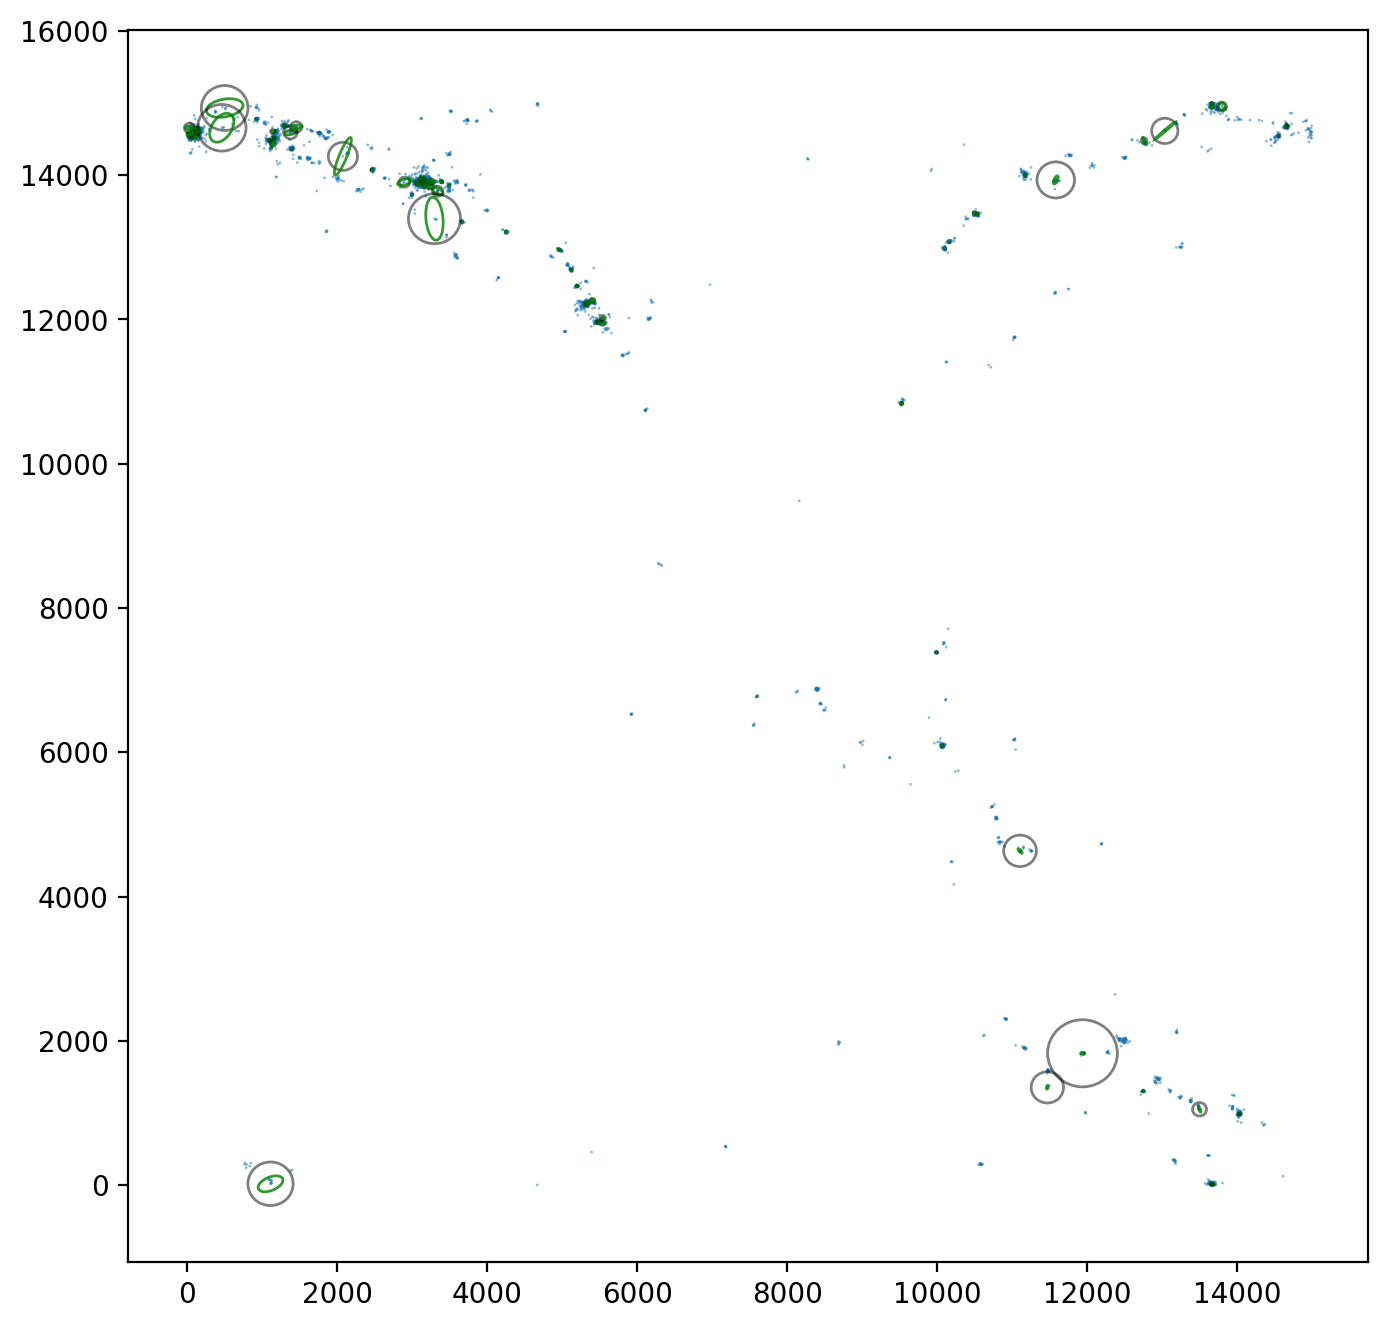

In [14]:
from matplotlib.patches import Circle, Ellipse

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pos[:, 0], pos[:, 1], s=1, ec='none', alpha=0.5)

def draw_circle(ax, center, radius):
    circle = Circle(center, radius, 
                    fill=False, edgecolor='k', lw=1, alpha=0.5)
    ax.add_patch(circle)

def draw_ellipse(ax, center, width, height, angle):
    ellipse = Ellipse(center, width, height, angle=angle, 
                      fill=False, edgecolor='g', lw=1, alpha=0.8)
    ax.add_patch(ellipse)


for p, h, w, v in zip(pos[::50], 
                      hsm[::50], 
                      eλ_2d[::50], 
                      ev_2d[::50]):

    # Calculate width, height, and angle of the ellipse
    width, height = 2*w
    angle = np.degrees(np.arctan2(*v[:, 0][::-1]))

    # Draw the smoothing circle and ellipse
    center = (p[0], p[1])
    draw_circle(ax, center, h)
    draw_ellipse(ax, center, width, height, angle)
    

In [15]:
fields = [fields_cic,
          fields_ada, 
          fields_iso,
          fields_ani]

/sctmp/maurbe/ipykernel_2945935/385514130.py:6: RuntimeWarning: divide by zero encountered in log10
  ax[j, 0].imshow(np.log10(fields[j][fov][...,0]), cmap='bone', vmin=-5)
/sctmp/maurbe/ipykernel_2945935/385514130.py:8: RuntimeWarning: divide by zero encountered in log10
  ax[j, 2].imshow(np.log10(fields[j][fov][...,-2]), cmap='binary_r')
/sctmp/maurbe/ipykernel_2945935/385514130.py:8: RuntimeWarning: invalid value encountered in log10
  ax[j, 2].imshow(np.log10(fields[j][fov][...,-2]), cmap='binary_r')
/sctmp/maurbe/ipykernel_2945935/385514130.py:9: RuntimeWarning: divide by zero encountered in log10
  ax[j, 3].imshow(np.log10(fields[j][fov][...,-1]), cmap='gist_heat')
/sctmp/maurbe/ipykernel_2945935/385514130.py:9: RuntimeWarning: invalid value encountered in log10
  ax[j, 3].imshow(np.log10(fields[j][fov][...,-1]), cmap='gist_heat')


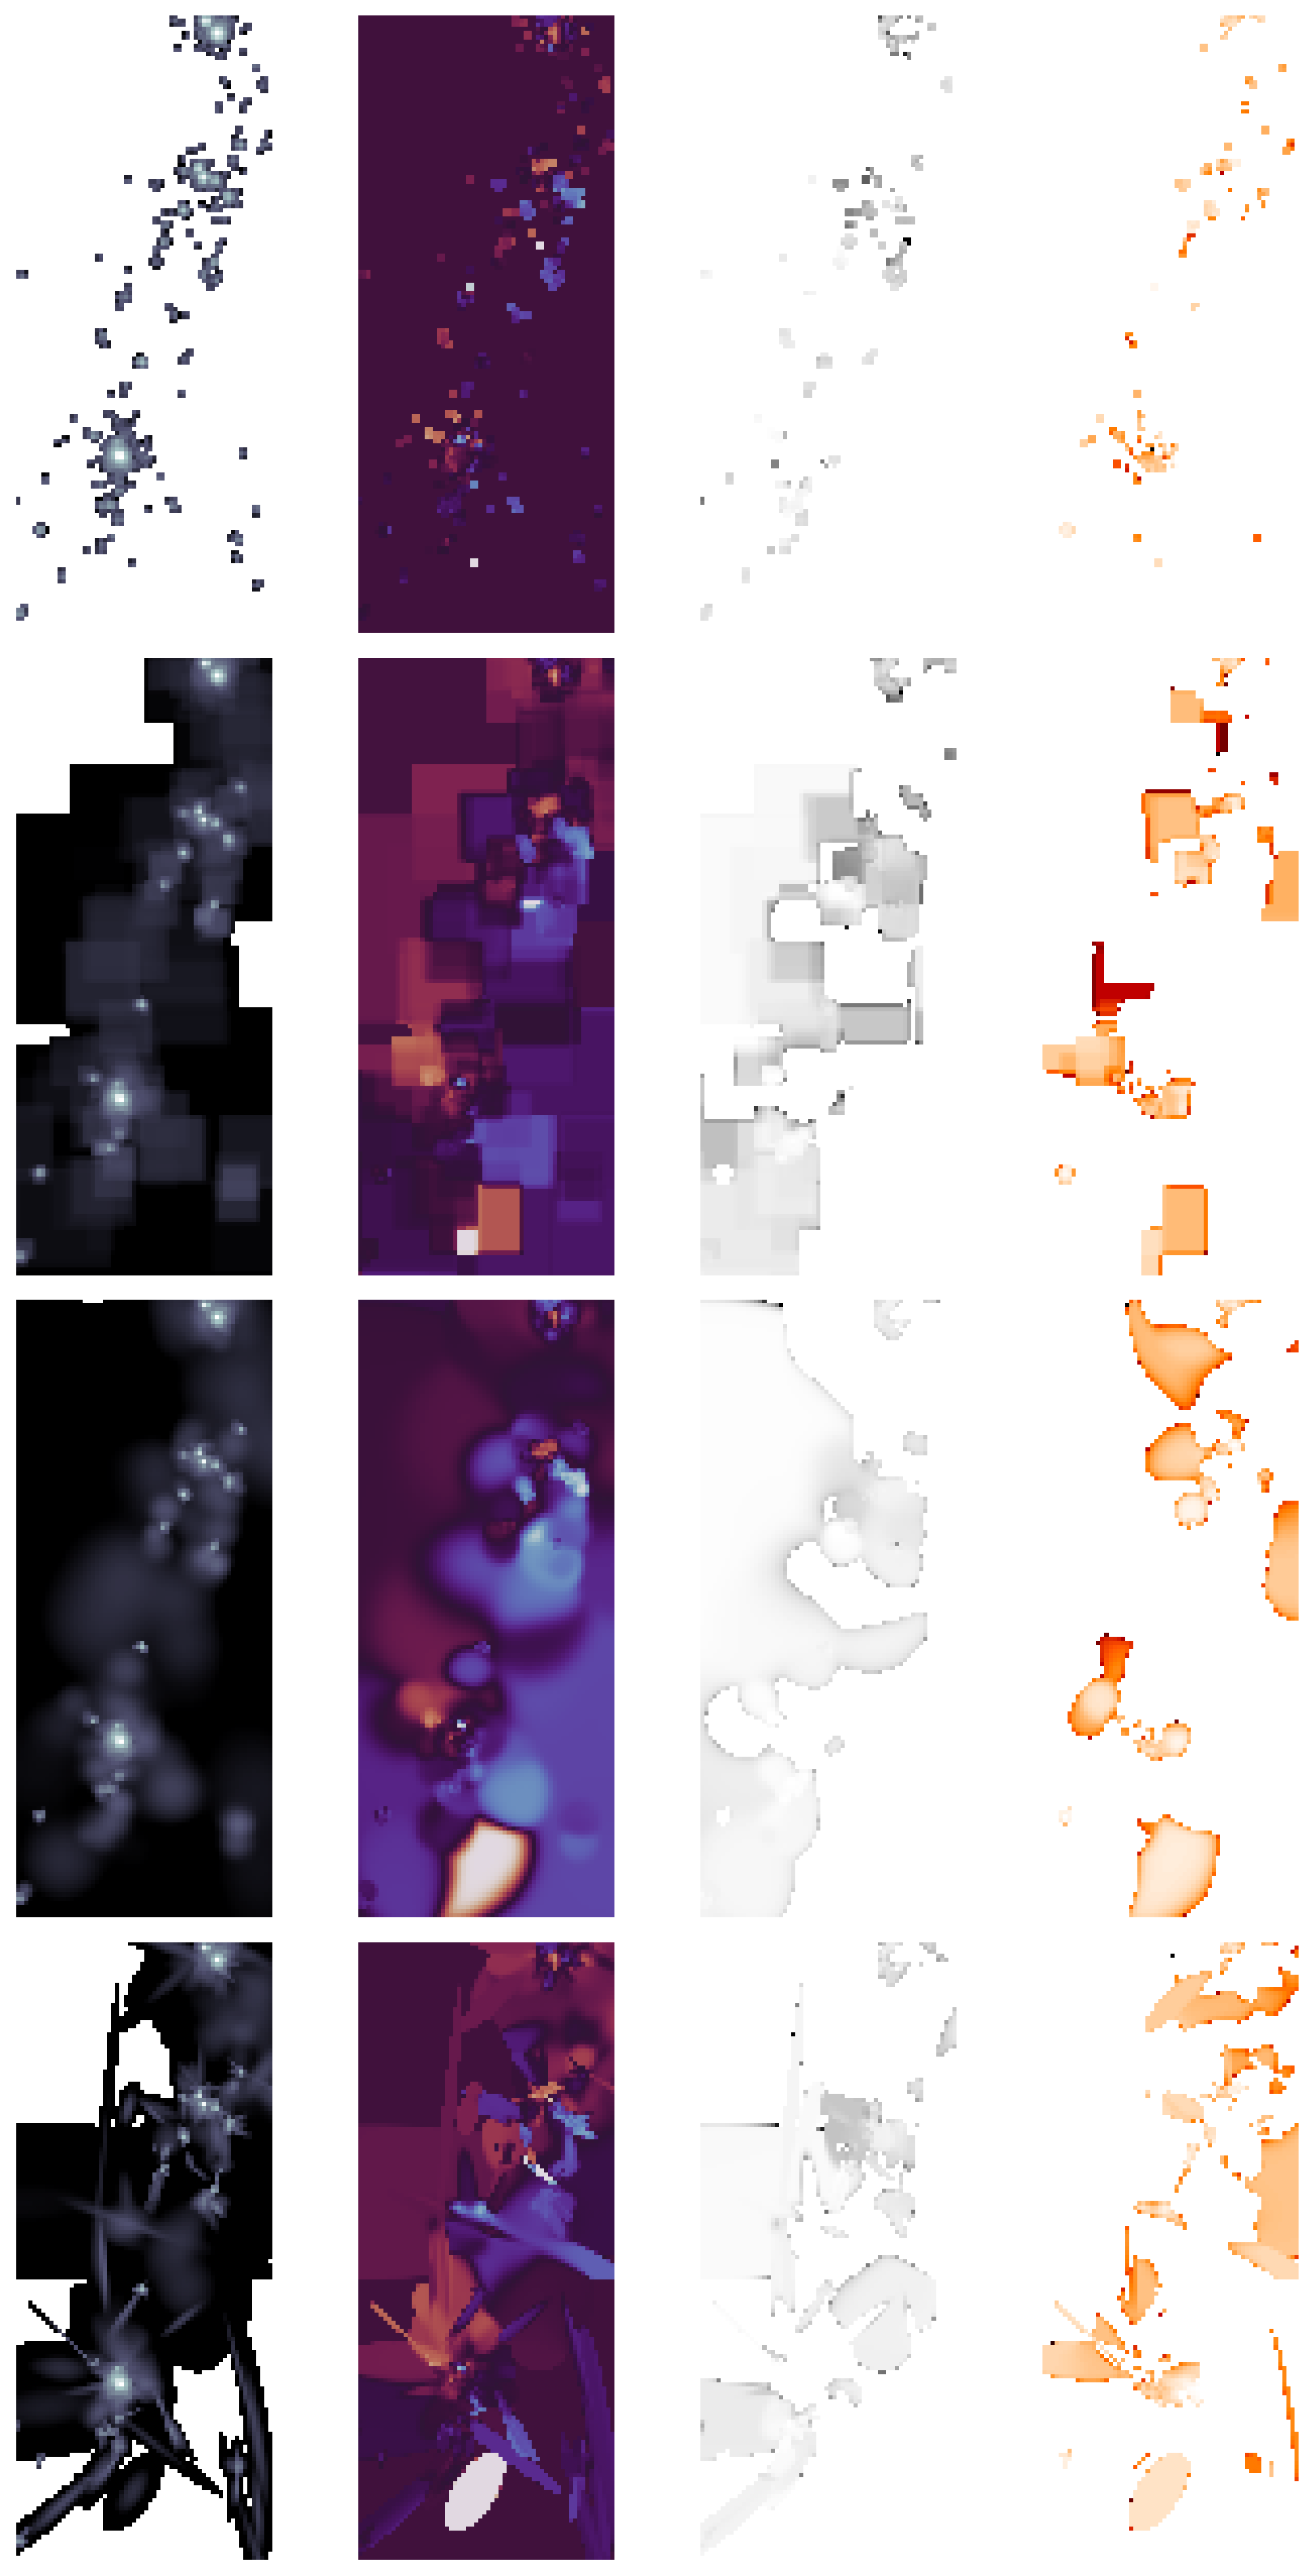

In [23]:
fig, ax = plt.subplots(4, 4, figsize=(9, 16))

for j in range(4):
    fov = np.s_[:150, 450:]

    ax[j, 0].imshow(np.log10(fields[j][fov][...,0]), cmap='bone', vmin=-5)
    ax[j, 1].imshow(fields[j][fov][...,1], cmap='twilight')
    ax[j, 2].imshow(np.log10(fields[j][fov][...,-2]), cmap='binary_r')
    ax[j, 3].imshow(np.log10(fields[j][fov][...,-1]), cmap='gist_heat')

for a in ax.flat:
    a.axis('off')

plt.tight_layout()
fig.savefig('plots/deposition_comparison_stars.png', transparent=True, dpi=300)
plt.show()